In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

In [2]:
data = pd.read_csv('../Dataset/btc_data.txt', header=None)

# Brief description of the data
data.describe()

,0
count,407.000000
mean,35482.748157
std,12585.738855
min,10070.590000
25%,27755.580000
50%,37287.160000
75%,46656.325000
max,58283.800000


In [3]:
def linearRegCostFunction(X, y, theta, Lambda):
    
    """
    Take in numpy array of  data X, labels y and theta, to return the regularized cost function and gradients
    of the linear regression model.
    
    """
    
    # Number of training examples 
    m = y.shape[0]
    
    #linear regression model
    h = np.dot(X,theta)
    
    cost = 1/(2*m) * np.sum((h - y)**2)
    reg_cost = cost + Lambda/(2*m) * (np.sum(theta[1:]**2))
    
    # compute the gradient
    grad_0= (1/m) * np.dot(X.transpose(),(h - y))[0]
    grad = (1/m) * np.dot(X.transpose(),(h - y))[1:] + (Lambda/m)* theta[1:]
       
    #  make the complete gradient a column vector
    grad_all=np.append(grad_0,grad)
    grad_all = grad_all.reshape((len(grad_all), 1))
    
    return reg_cost, grad_all

In [4]:
# Function to resize our data file according to the memory we want for our model
def resize_data_file(columns):
    ls = []
    with open('../Dataset/btc_data.txt') as f:
        for i in f.readlines():
            ls.append(i.strip())

    ls2 = []
    for i in ls:
        ls2.append(float(i))
    count = 0
    strr = ''
    str_ls = []
    
    # Get the divider to normalize our data
    max_num = int(max(ls2))
    divider = 0
    if max_num % 10000 == 0:
        divider = max_num
    else:
        divider = 10000 - (max_num % 10000) + max_num

    for i in ls2[:-(columns-1)]:
        for j in range(columns):
            if j == 0:
                strr = str(ls2[count] / divider)
            else:
                strr = strr + ',' + str(ls2[count + j] / divider)
        count += 1
        str_ls.append(strr)
    
    # Divide the total data into training (60%), validation (20%) and testing (the last 20%)
    training = round(len(str_ls) * 0.6)
    validation = round(len(str_ls) * 0.2) + training

    # Write the data with the correct number of columns into each file
    with open('../Dataset/training_data.txt', 'w') as f:
        for i in str_ls[:training]:
            print(i, file=f)
    
    with open('../Dataset/validation_data.txt', 'w') as f:
        for i in str_ls[training:validation]:
            print(i, file=f)
    
    with open('../Dataset/testing_data.txt', 'w') as f:
        for i in str_ls[validation:]:
            print(i, file=f)
            
    return divider, len(str_ls[validation:])

In [5]:
def resize_diff_file(columns):
    # Open the file with the price difference and save its data into a list
    ls = []
    with open('../Dataset/btc_data.txt') as f:
        for i in f.readlines():
            ls.append(float(i.strip()))

    # Get the list of differences
    diff_ls = getDiffData(ls)

    # Variables
    count = 0
    strr = ''
    str_ls = []
    
    # Normalize data
    x_array = np.array(diff_ls)
    arr = preprocessing.normalize([x_array], return_norm=True)

    normalized_array = arr[0][0]
    scalar_value = arr[1][0]
    
    # Divide the data in the correct number of columns
    for i in normalized_array[:-(columns-1)]:
        for j in range(columns):
            if j == 0:
                strr = str(normalized_array[count])
            else:
                strr = strr + ',' + str(normalized_array[count + j])
        count += 1
        str_ls.append(strr)

    # Divide the total data into training (60%), validation (20%) and testing (the last 20%)
    training = round(len(str_ls) * 0.6)
    validation = round(len(str_ls) * 0.2) + training

    # Write the data with the correct number of columns into each file
    with open('../Dataset/training_diff.txt', 'w') as f:
        for i in str_ls[:training]:
            print(i, file=f)
    
    with open('../Dataset/validation_diff.txt', 'w') as f:
        for i in str_ls[training:validation]:
            print(i, file=f)
    
    with open('../Dataset/testing_diff.txt', 'w') as f:
        for i in str_ls[validation:]:
            print(i, file=f)
            
    
    return scalar_value

In [6]:
def getDiffData(ls):
    
    # Variables
    diff_ls = []
    count = 1
    
    # Subtract each day to get the difference (p(1) - p(0), p(2) - p(1), ...) 
    # and save the differences in a list 
    for i in ls[:-1]:
        diff = round(ls[count] - i, 2)
        diff_ls.append(diff)
        count += 1
        
    # Return the list of differences between prices
    return diff_ls

In [7]:
def validationCurve (X, y, Xval, yval, learn_rate, num_iter):

    """
    Returns the best lambda and the respective train and cross validation set errors
    """
    m, n = X.shape
    mval = Xval.shape[0]  # Number of validation examples 
    
    error_train, error_val = [],[]
    
    theta_ini=np.zeros((n,1))
    theta = gradientDescent( X, y,theta_ini,learn_rate,num_iter,0)[0]

    #After the training is over, apply the trained model for train and validation data
    pred_train = np.dot(X,theta)
    pred_val = np.dot(Xval,theta)

    #Compute the train and validation error
    error_train_i = 1/(2*m) * np.sum((pred_train - y)**2)
    error_val_i = 1/(2*mval) * np.sum((pred_val - yval)**2)

    error_train.append(error_train_i)
    error_val.append(error_val_i)
    
    #Choose the best lambda to be the one that minimizes the validation error
    ind = np.argmin(error_val)
        
    return error_train, error_val

In [8]:
def gradientDescent(X,y,theta,learn_rate,num_iters,Lambda):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    
    J_history =[]
    for i in range(num_iters):
        cost, grad = linearRegCostFunction(X,y,theta,Lambda)
        theta = theta - (learn_rate * grad)
        J_history.append(cost)
    
    return theta, J_history

In [9]:

# Columns we want to try
cols = [2, 3, 4, 5, 6, 7]

# Parameters of the iterations
num_iter = 50000
Lambda = 0
learn_rate = 0.001
print('Number of iterations: ' + str(num_iter) + '\n')

minError = (1, 0)

# Variable lists
J_history_ls = []
error_train_ls = []
error_val_ls = []
error_train_validation_ls = []
error_val_validation_ls = []
testing_num = 0

# Iterate through all the columns
for col in cols:
   
    # Resize the text file with the correct number of columns
    divider, testing_num = resize_data_file(col)

    # Read each text file
    training_data = pd.read_csv('../Dataset/training_data.txt', header=None)
    validation_data = pd.read_csv('../Dataset/validation_data.txt', header=None)
    testing_data = pd.read_csv('../Dataset/testing_data.txt', header=None)

    # Parse data
    training_data = training_data.values
    validation_data = validation_data.values
    testing_data = testing_data.values
    
    # Training data
    X = training_data[:, :(col - 1)]
    y = training_data[:, (col - 1)]
    y = y.reshape((len(y), 1))
    m = len(y)
    X_1 = np.append(np.ones((m,1)), X, axis=1)
    
    # Validation data
    Xval = validation_data[:, :(col - 1)]
    yval = validation_data[:, (col - 1)]
    yval = yval.reshape((len(yval), 1))
    mval = len(yval)
    Xval_1 = np.append(np.ones((mval,1)), Xval, axis=1)
    
    # Testing data
    Xtest = testing_data[:, :(col - 1)]
    ytest = testing_data[:, (col - 1)]
    ytest = ytest.reshape((len(ytest), 1))
    mtest = len(ytest)
    Xtest_1 = np.append(np.ones((mtest,1)), Xtest, axis=1)
    
    # Initialize all theta at 0. 
    initial_theta = np.zeros((X.shape[1] + 1, 1))

    theta, J_history = gradientDescent(X_1,y,initial_theta,learn_rate,num_iter,Lambda)
    J_history_ls.append(J_history)
    
    # Learning curve
    mval = Xval.shape[0]  # Number of validation examples 
    Xval_1 = np.append(np.ones((mval,1)),Xval,axis=1)

    # Validation curve

    error_train_validation, error_val_validation = validationCurve(X, y, Xval, yval, learn_rate, 1)
    error_train_validation_ls.append(error_train_validation)
    error_val_validation_ls.append(error_val_validation)

    # Initialize all theta at 0. 
    theta_ini = np.zeros((X.shape[1], 1))
    theta_poly = gradientDescent(X, y,theta_ini,learn_rate,num_iter,0)[0]
    
    pred = np.dot(X,theta_poly)
    Etrain = 1/(2*m) * np.sum((pred - y)**2)

    pred_val = np.dot(Xval,theta_poly)
    Eval = 1/(2*mval) * np.sum((pred_val - yval)**2)
    
    pred_test = np.dot(Xtest, theta_poly)
    Etest = 1/(2*mtest) * np.sum((pred_test - ytest)**2)
    
    print('Columns: ' + str(col))

    print('Number of training days: ' + str(col - 1))
    print('Testing error: ' + str(Etest) + '\n')
    
    if Etest < minError[0]:
        minError = (Etest, col-1)
print('Smallest error: ' + str(minError))

Number of iterations: 50000

Columns: 2
Number of training days: 1
Testing error: 0.00038188539213707964

Columns: 3
Number of training days: 2
Testing error: 0.00047131095356671876

Columns: 4
Number of training days: 3
Testing error: 0.0005272499329352024

Columns: 5
Number of training days: 4
Testing error: 0.0005701076675469358

Columns: 6
Number of training days: 5
Testing error: 0.0006196047091372425

Columns: 7
Number of training days: 6
Testing error: 0.0006978975395869201

Smallest error: (0.00038188539213707964, 1)


Text(0.5, 1.0, 'Regularized cost function using gradient descent')

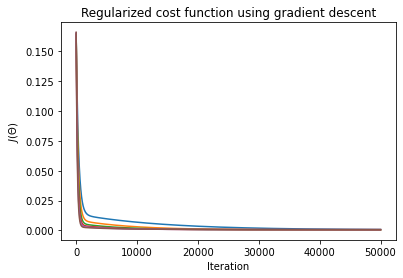

In [10]:
for j in J_history_ls:
    plt.plot(j)
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Regularized cost function using gradient descent")

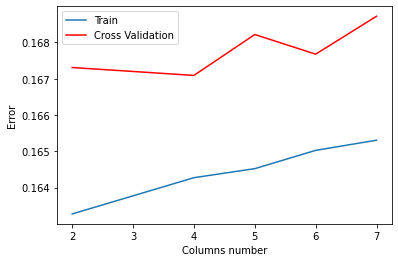

In [11]:
plt.plot(cols,error_train_validation_ls,label="Train")
plt.plot(cols,error_val_validation_ls,label="Cross Validation",color="r")
plt.xlabel("Columns number")
plt.ylabel("Error")
plt.legend()

### As we can see, the best number of columns to use is 4, meaning we will use the price of the last 3 days to calculate the price for tomorrow (or in more days)

In [12]:
best_col = 4

J_history_ls = []
J_history_diff_ls = []

# Resize for best column number
resize_data_file(best_col)
# For the diff
scalar_val = resize_diff_file(best_col - 1)

# Read the data again
training_data = pd.read_csv('../Dataset/training_data.txt', header=None)
training_data_diff = pd.read_csv('../Dataset/training_diff.txt', header=None)

# Parse data
training_data = training_data.values
training_data_diff = training_data_diff.values
    
# Training data
X = training_data[:, :(best_col - 1)]
y = training_data[:, (best_col - 1)]
y = y.reshape((len(y), 1))
m = len(y)
X_1 = np.append(np.ones((m,1)), X, axis=1)

# Training data from the differences
X_diff = training_data_diff[:, :(best_col - 2)]
y_diff = training_data_diff[:, (best_col - 2)]
y_diff = y_diff.reshape((len(y_diff), 1))
m_diff = len(y_diff)
X_1_diff = np.append(np.ones((m_diff,1)), X_diff, axis=1)

# Gradient Descent with more iterations
Lambda = 0
learn_rate = 0.001
num_iter = 300000

# Initialize all theta at 0. 
initial_theta = np.zeros((X.shape[1] + 1, 1))
initial_theta_diff = np.zeros((X_diff.shape[1] + 1, 1))

print('With normal price training:')
theta, J_history = gradientDescent(X_1, y, initial_theta, learn_rate, num_iter, Lambda)
J_history_ls.append(J_history)
print('h(x) = ' + str(round(theta[0,0], 4)) + ' + ' + str(round(theta[1,0], 4)) + 'x + ' + \
      str(round(theta[2,0], 4)) + 'x2 + ' + str(round(theta[3,0], 4)) + 'x3')

print('\nWith price difference training:')
theta_diff, J_history_diff = gradientDescent(X_1_diff, y_diff, initial_theta_diff, learn_rate, num_iter, Lambda)
J_history_diff_ls.append(J_history_diff)
print('h(x) = ' + str(round(theta_diff[0,0], 4)) + ' + ' + str(round(theta_diff[1,0], 4)) + 'x + ' + \
      str(round(theta_diff[2,0], 4)) + 'x2')

With normal price training:
h(x) = 0.0112 + 0.2545x + 0.318x2 + 0.4104x3

With price difference training:
h(x) = 0.0021 + 0.055x + -0.0448x2


In [13]:
# Predict from the previous prices
def predict(x, theta):
    h = np.dot(x, theta)
    return h[0]

def predictInNDays(x, theta, days):
    if days < 1:
        return x[0]
    elif days == 1:
        return predict(x, theta) 
    else:
        final_x = predict(x, theta)
        # Each day becomes the day before
        for i in range(1, len(x) - 1):
            x[i] = x[i + 1]
        x[len(x) - 1] = final_x
        return predictInNDays(x, theta, days - 1)

# Predict from the differences
def predictDiff(x, theta):
    h = np.dot(x, theta)
    return h[0]

def predictDiffInNDays(x, theta, days):
    if days < 1:
        return x[0]
    elif days == 1:
        return predictDiff(x, theta) 
    else:
        final_x = predictDiff(x, theta)
        # Each day becomes the day before
        for i in range(1, len(x) - 1):
            x[i] = x[i + 1]
        x[len(x) - 1] = final_x
        
        return predictDiffInNDays(x, theta, days - 1)

##  In the next cell, the user can choose:
#### - The price values of the last days
#### - The number of days from now to predict the value

In [14]:
# Pass the price of the last two days
price_2_days_ago = 41758.73
price_yesterday = 43611.23
price_today = 44303.08

# Number of days from now, we want to predict the value (1 if tomorrow)
days_from_now = 1

In [15]:
# Calculate the differences
diff1, diff2 = price_yesterday - price_2_days_ago, price_today - price_yesterday

x_sample = [(price_2_days_ago/divider), (price_yesterday/divider), (price_today/divider)]
x_sample = np.append(1, x_sample)

x_sample_diff = [(diff1/scalar_val), (diff2/scalar_val)]
x_sample_diff = np.append(1, x_sample_diff)

pre = predictInNDays(x_sample, theta, days_from_now) 
pre_diff = predictDiffInNDays(x_sample_diff, theta_diff, days_from_now)

price = round(pre * divider, 2)
diff_price = round(price_today + pre_diff * scalar_val, 2)

print('Price in ' + str(days_from_now) + ' day(s) with price data: ' + str(price) + '€')
print('Price in ' + str(days_from_now) + ' day(s) with differece data: ' + str(diff_price) + '€')

# Final price prediction
final_price = round((price + diff_price) / 2, 2)
print('Final price in ' + str(days_from_now) + ' day(s): ' + str(final_price) + '€')


Price in 1 day(s) with price data: 43354.59€
Price in 1 day(s) with differece data: 44437.38€
Final price in 1 day(s): 43895.98€


### Now we proceed to compute the error of the 2 features, and the final predict

In [ ]:
# Calculate the errors
num_iter = 50000

# Normal data values
testing_data = pd.read_csv('../Dataset/testing_data.txt', header=None)
testing_data = testing_data.values

Xtest = testing_data[:, :(best_col - 1)]
ytest = testing_data[:, (best_col - 1)]
ytest = ytest.reshape((len(ytest), 1))
mtest = len(ytest)
Xtest_1 = np.append(np.ones((mtest,1)), Xtest, axis=1)

theta_ini = np.zeros((X.shape[1], 1))
theta_poly = gradientDescent(X, y,theta_ini,learn_rate,num_iter,0)[0]
    
pred_test = np.dot(Xtest, theta_poly)
Etest = 1/(2*mtest) * np.sum((pred_test - ytest)**2)

print('Testing error for normal data training: ' + str(Etest))

# Difference data values
testing_data_diff = pd.read_csv('../Dataset/testing_diff.txt', header=None)
testing_data_diff = testing_data_diff.values

Xtest_diff = testing_data_diff[:, :(best_col - 2)]
ytest_diff = testing_data_diff[:, (best_col - 2)]
ytest_diff = ytest_diff.reshape((len(ytest_diff), 1))
mtest_diff = len(ytest_diff)
Xtest_1_diff = np.append(np.ones((mtest_diff,1)), Xtest_diff, axis=1)

theta_ini_diff = np.zeros((X_diff.shape[1], 1))
theta_poly_diff = gradientDescent(X_diff, y_diff,theta_ini_diff,learn_rate,num_iter,0)[0]

last_X_value = testing_data[:, (best_col - 2)]

pred_test_diff = np.dot(Xtest_diff, theta_poly_diff)

pred_test_diff_ls = []
for i in pred_test_diff * scalar_val:
    pred_test_diff_ls.append(i[0])

pred_test_diff_final = (last_X_value * divider + pred_test_diff_ls) / 60000
pred_test_diff_final = pred_test_diff_final.reshape((len(pred_test_diff_final), 1))

Etest_diff = 1/(2*mtest) * np.sum((pred_test_diff_final - ytest)**2)

print('Testing error for difference data training: ' + str(Etest_diff))

# For the average of the 2 features
average = (pred_test_diff_final + pred_test) / 2

Etest_average = 1/(2*mtest) * np.sum((average - ytest)**2)

print('Testing error for the average of the 2 features: ' + str(Etest_average))

In [ ]:
# Graphic of the Bitcoin prics vs predicted price
arr_graph = pd.read_csv('../Dataset/btc_data.txt', header=None)
arr_graph = arr_graph.values
arr_graph = arr_graph[len(arr_graph) - testing_num:]
y_real = [] 

for i in arr_graph:
    y_real.append(i[0])


x_real = list(range(0, len(arr_graph)))
x_predicted = list(range(best_col - 1, len(arr_graph)))

i = 0
y_predicted = []
for i in range(best_col - 1, len(arr_graph)):
    price_2_days_ago = arr_graph[i-3]
    price_yesterday = arr_graph[i-2]
    price_today = arr_graph[i-1]
    
    x_sample = [(price_2_days_ago/divider), (price_yesterday/divider), (price_today/divider)]
    x_sample = np.append(1, x_sample)

    # Number of days from now, we want to predict the value (1 if tomorrow)
    days_from_now = 1

    pre = predictInNDays(x_sample, theta, days_from_now) 

    price = round(pre * divider, 2)
    y_predicted.append(price)
    
plt.plot(x_predicted, y_predicted)
plt.plot(x_real, y_real)
plt.legend(["Predicted Values", "Real Values"], loc ="lower right")
plt.title("Real Price vs Predicted Price of testing data (Based on last three days)")
plt.xlabel("Day")
plt.ylabel("Price")
plt.show()

In [ ]:
# Graphic of the Bitcoin prics vs predicted price using differences

x_predicted_diff = list(range(best_col - 1, len(arr_graph)))

i = 0
y_predicted_diff = []

for i in range(best_col - 1, len(arr_graph)):
    
    # 3 days
    price_2_days_ago = arr_graph[i-3]
    price_yesterday = arr_graph[i-2]
    price_today = arr_graph[i-1]
    
    # 2 differences
    diff1, diff2 = price_yesterday - price_2_days_ago, price_today - price_yesterday
    
    x_sample_diff = [(diff1 / scalar_val), (diff2 / scalar_val)]
    x_sample_diff = np.append(1, x_sample_diff)
    
    # Number of days from now, we want to predict the value (1 if tomorrow)
    days_from_now = 1

    pre = predictDiffInNDays(x_sample_diff, theta_diff, days_from_now)
    
    diff_price = price_today + pre * scalar_val
    
    y_predicted_diff.append(round(diff_price[0], 2))
    
plt.plot(x_predicted_diff, y_predicted_diff)
plt.plot(x_real, y_real)

plt.legend(["Predicted Values", "Real Values"], loc ="lower right")
plt.title("Real Price vs Predicted Price of testing data using differences")
plt.xlabel("Day")
plt.ylabel("Predicted price")
plt.show()

In [ ]:
# Final graphic of the Bitcoin prics vs predicted price using the mean of the previous features
y_predicted_final = []
i = 0
for val in y_predicted_diff:
    y_predicted_final.append(round((val + y_predicted[i]) / 2, 2))
    i += 1
    
plt.plot(x_predicted_diff, y_predicted_final)
plt.plot(x_real, y_real)

plt.legend(["Predicted Values", "Real Values"], loc ="lower right")
plt.title("Real Price vs Predicted Price of testing data Final (Based on last three days)")
plt.xlabel("Day")
plt.ylabel("Predicted price")
plt.show()